# Preparation 



In [1]:
#https://www.kaggle.com/typewind/draw-a-radar-chart-with-python-in-a-simple-way
#https://stackoverflow.com/questions/52910187/how-to-make-a-polygon-radar-spider-chart-in-python

import matplotlib.pyplot as plt
%matplotlib inline
from radar_chart import *
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
df=pd.read_csv("listing_xqueens_11364.csv")
label=['full_address','beds','baths','size_sqft_int','walk_score' , 'bike_score' , 'price_num']
data = df[label]#.loc[1]
data = data.dropna()
data['test'] =.7
data['walk_score_per'] = data['walk_score']/100
data[ 'bike_score_per']=data[ 'bike_score']/100
data['beds'] = data['beds']/10
data['baths'] = data['baths']/10

min_max_col = [ 'size_sqft_int', 'price_num' ]

for i  in min_max_col:
    data[i+'_s'] =MinMaxScaler().fit_transform(data[i].values.reshape(-1, 1))

#data= pd.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=['beds','baths'],sparse=False, drop_first=False, dtype=None)

labels=np.array(['price_num_s' ,'test','beds','baths','size_sqft_int_s','walk_score_per' , 'bike_score_per'  ])
#labels=np.array(['price_num_s' ,'test','size_sqft_int_s','walk_score_per' , 'bike_score_per'  ])

stats=data[labels].loc[13].values
#stats=np.concatenate((stats,[stats[0]]))
display(data.head(3))
print(stats)

,full_address,beds,baths,size_sqft_int,walk_score,bike_score,price_num,test,walk_score_per,bike_score_per,size_sqft_int_s,price_num_s
1,"330 Herzl St, Brooklyn, NY 11212",0.8,0.60,1600.0,44.0,58.0,700000.0,0.7,0.44,0.58,0.092033,0.282795
3,"268 Amboy St, Brooklyn, NY 11212",0.3,0.15,1116.0,44.0,58.0,299000.0,0.7,0.44,0.58,0.000000,0.018457
5,"1892 Strauss St, Brooklyn, NY 11212",0.4,0.25,2000.0,44.0,58.0,589000.0,0.7,0.44,0.58,0.168093,0.209624


[0.41397495 0.7        0.9        0.35       0.40768207 0.44
 0.58      ]


# Draw the Radar Chart
 

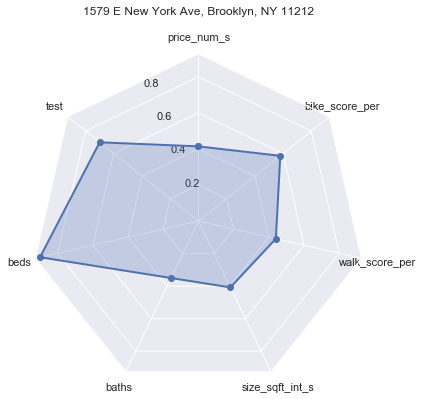

In [4]:

sns.set()

N = len(stats)
theta = radar_factory(N, frame='polygon')

spoke_labels = labels
case_data = stats
title = data.loc[13,'full_address']
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)



ax.set_thetagrids(theta  * 180/np.pi, labels)

ax.set_title(title,  position=(0.5, 1.1), ha='center')

#for d in case_data:
line = ax.plot(theta, stats  , 'o-', linewidth=2)
ax.fill(theta, stats,  alpha=0.25)
ax.set_varlabels(spoke_labels)
ax.grid(True)
plt.show()



# Radar chart package taken form :<br>
https://stackoverflow.com/questions/52910187/how-to-make-a-polygon-radar-spider-chart-in-python


In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta






In [6]:
import plotly.express as px
import pandas as pd

fig = px.line_polar( stats,r= theta, theta= spoke_labels, line_close=True)
fig.update_traces(fill='toself')
fig.show()